## Configuration Cell

In [1]:
batch_size = 64
module = 'LSTM'
epochs = 12
optim_name = 'adam'
learning_rate = 1e-3
CLIP = 1
teacher_forcing_ratio = 0.35
beam_width = 2
no_encoder_decoder_layers = 3
hidden_layer_size = 512
dropout = 0.32
enc_embedding_dim = 0
dec_embedding_dim = 0
attention = True

## Import Libraries

In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import random
import math
import time
from util import *

import operator
from queue import PriorityQueue

## Set up device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model name and create directory for checkpoint

In [4]:
modelName = 'Best_Dakshina_Hi_atten'

In [5]:
import os
try:
    os.makedirs(modelName+"/checkpoint")
    os.makedirs(modelName+"/best_model")
except:
    print("directory already present")

directory already present


In [6]:
ckp_path = "./"+modelName+"/checkpoint/current_checkpoint.pt"
best_ckp_path = "./"+modelName+"/best_model/best_model.pt"

## Set up wandb

In [7]:
import wandb
wandb.init(project=modelName)

wandb: Currently logged in as: rayanz (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Set up Dataset

In [8]:
with open(r"C:\Users/Rayan Zaki/Downloads/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv", 'r', encoding="utf8") as f:
    train_lines = f.read().split("\n")
    
with open(r"C:\Users/Rayan Zaki/Downloads/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv", 'r', encoding="utf8") as f:
    val_lines = f.read().split("\n")
    
with open(r"C:\Users/Rayan Zaki/Downloads/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv", 'r', encoding="utf8") as f:
    test_lines = f.read().split("\n")

In [9]:
train_num_samples = len(train_lines)
val_num_samples = len(val_lines)
test_num_samples = len(test_lines)

In [10]:
train_input_texts = []
train_target_texts = []

val_input_texts = []
val_target_texts = []

test_input_texts = []
test_target_texts = []

input_characters = set()
target_characters = set()

In [11]:
## Train Data ##

for line in train_lines[: min(train_num_samples, len(train_lines) - 1)]:
    target_text, input_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    train_input_texts.append(input_text)
    train_target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters.add(' ')
target_characters.add(' ')
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

train_max_encoder_seq_length = max([len(txt) for txt in train_input_texts])
train_max_decoder_seq_length = max([len(txt) for txt in train_target_texts])

print("Number of train samples:", len(train_input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)

print("Max train sequence length for inputs:", train_max_encoder_seq_length)
print("Max train sequence length for outputs:", train_max_decoder_seq_length)

Number of train samples: 44204
Number of unique input tokens: 27
Number of unique output tokens: 66
Max train sequence length for inputs: 20
Max train sequence length for outputs: 21


In [12]:
## Val Data ##

for line in val_lines[: min(val_num_samples, len(val_lines) - 1)]:
    target_text, input_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    val_input_texts.append(input_text)
    val_target_texts.append(target_text)
    
val_max_encoder_seq_length = max([len(txt) for txt in val_input_texts])
val_max_decoder_seq_length = max([len(txt) for txt in val_target_texts])

print("Number of val samples:", len(val_input_texts))

print("Max val sequence length for inputs:", val_max_encoder_seq_length)
print("Max val sequence length for outputs:", val_max_decoder_seq_length)

Number of val samples: 4358
Max val sequence length for inputs: 18
Max val sequence length for outputs: 16


In [13]:
## Test Data ##

for line in test_lines[: min(test_num_samples, len(test_lines) - 1)]:
    target_text, input_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    test_input_texts.append(input_text)
    test_target_texts.append(target_text)
    
test_max_encoder_seq_length = max([len(txt) for txt in test_input_texts])
test_max_decoder_seq_length = max([len(txt) for txt in test_target_texts])

print("Number of test samples:", len(test_input_texts))

print("Max test sequence length for inputs:", test_max_encoder_seq_length)
print("Max test sequence length for outputs:", test_max_decoder_seq_length)

Number of test samples: 4502
Max test sequence length for inputs: 16
Max test sequence length for outputs: 17


In [14]:
# token indices
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

# Train data
encoder_input_data_train = np.zeros(
    (len(train_input_texts), train_max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data_train = np.zeros(
    (len(train_input_texts), train_max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

# Val data
encoder_input_data_val = np.zeros(
    (len(val_input_texts), train_max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data_val = np.zeros(
    (len(val_input_texts), train_max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

# Test data
encoder_input_data_test = np.zeros(
    (len(test_input_texts), train_max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data_test = np.zeros(
    (len(test_input_texts), train_max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [15]:
## Train Data ##

for i, (input_text, target_text) in enumerate(zip(train_input_texts, train_target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data_train[i, t, input_token_index[char]] = 1. 
    encoder_input_data_train[i, t + 1:, input_token_index[' ']] = 1.
    
    for t, char in enumerate(target_text):
        decoder_input_data_train[i, t, target_token_index[char]] = 1.
    decoder_input_data_train[i, t + 1:, target_token_index[' ']] = 1.
    
## Val Data ##

for i, (input_text, target_text) in enumerate(zip(val_input_texts, val_target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data_val[i, t, input_token_index[char]] = 1. 
    encoder_input_data_val[i, t + 1:, input_token_index[' ']] = 1.
    
    for t, char in enumerate(target_text):
        decoder_input_data_val[i, t, target_token_index[char]] = 1.
    decoder_input_data_val[i, t + 1:, target_token_index[' ']] = 1.
    
## Test Data ##

for i, (input_text, target_text) in enumerate(zip(test_input_texts, test_target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data_test[i, t, input_token_index[char]] = 1. 
    encoder_input_data_test[i, t + 1:, input_token_index[' ']] = 1.
    
    for t, char in enumerate(target_text):
        decoder_input_data_test[i, t, target_token_index[char]] = 1.
    decoder_input_data_test[i, t + 1:, target_token_index[' ']] = 1.

In [16]:
# Convert data to tensors so that u can pass through dataloaders

encoder_inp_train = torch.stack([torch.from_numpy(np.array(i)) for i in encoder_input_data_train])
decoder_inp_train = torch.stack([torch.from_numpy(np.array(i)) for i in decoder_input_data_train])

encoder_inp_val = torch.stack([torch.from_numpy(np.array(i)) for i in encoder_input_data_val])
decoder_inp_val = torch.stack([torch.from_numpy(np.array(i)) for i in decoder_input_data_val])


encoder_inp_test = torch.stack([torch.from_numpy(np.array(i)) for i in encoder_input_data_test])
decoder_inp_test = torch.stack([torch.from_numpy(np.array(i)) for i in decoder_input_data_test])

In [17]:
#batch_size = 64

train_dataset = torch.utils.data.TensorDataset(encoder_inp_train, decoder_inp_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

val_dataset = torch.utils.data.TensorDataset(encoder_inp_val, decoder_inp_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)#, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(encoder_inp_test, decoder_inp_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)#, shuffle = True)

## Build Model

In [18]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)
        attn_energies = self.score(h, encoder_outputs) 
        return F.softmax(attn_energies, dim=1).unsqueeze(1) 

    def score(self, hidden, encoder_outputs):
        energy = F.relu(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [19]:
class Encoder(nn.Module):
    def __init__(self,  num_encoder_tokens, hid_dim, n_layers, dropout, enc_embedding_dim = 0, module='LSTM'):
        super(Encoder,self).__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.module = module
        self.embedding_dim = enc_embedding_dim
        self.enc_inp = num_encoder_tokens
        if self.embedding_dim !=0:
            self.enc_inp = self.embedding_dim
            self.embedding = nn.Embedding(num_encoder_tokens, self.embedding_dim)
            
        if self.module =='LSTM':
            self.rnn = nn.LSTM(self.enc_inp, hid_dim, n_layers, dropout = dropout)
        elif self.module == 'RNN':
            self.rnn = nn.RNN(self.enc_inp, hid_dim, n_layers, dropout = dropout)
        elif self.module == 'GRU':
            self.rnn = nn.GRU(self.enc_inp, hid_dim, n_layers, dropout = dropout)
        
    def forward(self, inp):
        
        inp = inp.transpose(0,1)  # check input dimensions before embedding. Currently : (T, N)
        if self.embedding_dim !=0:
            inp = inp.argmax(2)
            inp = self.embedding(inp)
            
        outputs, hidden_cell = self.rnn(inp)
        
        return outputs, hidden_cell

In [20]:
class Decoder(nn.Module):
    def __init__(self, num_decoder_tokens, hid_dim, n_layers, dropout, dec_embedding_dim = 0, module='LSTM', atten=False):
        super(Decoder,self).__init__()
        
        self.output_dim = num_decoder_tokens
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.module = module
        self.atten = atten
        self.embedding_dim = dec_embedding_dim
        self.dec_inp = num_decoder_tokens
        
        if self.embedding_dim !=0:
            self.dec_inp = self.embedding_dim
            self.embedding = nn.Embedding(num_decoder_tokens, self.embedding_dim)
        
        if self.atten == False:
            if module=='LSTM':
                self.rnn = nn.LSTM(self.dec_inp, hid_dim, n_layers, dropout = dropout)
            if module=='RNN':
                self.rnn = nn.RNN(self.dec_inp, hid_dim, n_layers, dropout = dropout)
            if module=='GRU':
                self.rnn = nn.GRU(self.dec_inp, hid_dim, n_layers, dropout = dropout)
                
            self.fc_out = nn.Linear(self.hid_dim, self.output_dim)
                
        else:
            self.attention = Attention(self.hid_dim)
            
            if module=='LSTM':
                self.rnn = nn.LSTM(self.hid_dim + self.dec_inp, hid_dim, n_layers, dropout = dropout)
            if module=='RNN':
                self.rnn = nn.RNN(self.hid_dim + self.dec_inp, hid_dim, n_layers, dropout = dropout)
            if module=='GRU':
                self.rnn = nn.GRU(self.hid_dim + self.dec_inp, hid_dim, n_layers, dropout = dropout)
                
            self.fc_out = nn.Linear(self.hid_dim * 2, self.output_dim)
        
        
        
    def forward(self, inp, hidden_cell, encoder_states):
        
        if isinstance(hidden_cell, tuple):
            hidden = hidden_cell[0]
            cell = hidden_cell[1]
        else:
            hidden = hidden_cell
        
        if self.embedding_dim !=0:
            inp = inp.argmax(2)
            inp = self.embedding(inp)
        
        if self.atten == False:
            if self.module == 'LSTM':
                output, hidden = self.rnn(inp, (hidden, cell))
            else:
                output, hidden = self.rnn(inp,hidden)

            prediction = self.fc_out(output.squeeze(0))
            return prediction, hidden
        
        else:
            attn_weights = self.attention(hidden[-1], encoder_states)  # why -1 ? wat is dim of hidden?
            context = attn_weights.bmm(encoder_states.transpose(0, 1))
            context = context.transpose(0, 1)
            rnn_inp = torch.cat([inp, context], 2) 
            
            if self.module == 'LSTM':
                output, hidden = self.rnn(rnn_inp, (hidden, cell))
            else:
                output, hidden = self.rnn(rnn_inp, hidden)
            
            output = output.squeeze(0) 
            context = context.squeeze(0)
            output = self.fc_out(torch.cat([output, context], 1))
            
            return output, hidden, attn_weights

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.atten = self.decoder.atten
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, to_train, teacher_forcing_ratio = 0.5, beam_width = 3):
        
        if to_train == True:
        
            trg = trg.transpose(0,1)
            batch_size = trg.shape[1]
            trg_len = trg.shape[0]
            trg_vocab_size = self.decoder.output_dim
            
            outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

            enc_output, hidden_cell = self.encoder(src)
            inp = trg[0,:]

            for t in range(1, trg_len):
                
                if self.atten == False:
                    prediction, hidden_cell = self.decoder(inp.unsqueeze(0), hidden_cell, enc_output) # recursively set hidden, cell
                else:
                    prediction, hidden_cell, atten_weights = self.decoder(inp.unsqueeze(0), hidden_cell, enc_output)
                outputs[t] = prediction
                teacher_force = random.random() < teacher_forcing_ratio
                top1 = prediction.argmax(1)
                top1_one_hot = torch.zeros_like(prediction).to(self.device)
                top1_one_hot[:,top1] = 1.

                inp = trg[t] if teacher_force else top1_one_hot

            return outputs
        
        else :
            batch_size = trg.shape[0]
            trg_len = trg.shape[1]
            trg_vocab_size = self.decoder.output_dim

            enc_output, hidden_cell = self.encoder(src)
            outputs = self.beam_decode(beam_width, trg, hidden_cell, enc_output)
            
            return outputs
        
    def beam_decode(self, beam_width, target_tensor, decoder_hiddens, encoder_outputs=None):
        
        target_tensor = target_tensor.transpose(0,1)
        beam_width = beam_width
        topk = 1
        decoded_batch = []
        atten_weights_batch = []
        batch_loss = []
        EOS_token = target_token_index['\n']
        
        criterion_infer = torch.nn.CrossEntropyLoss(ignore_index = target_token_index[' '])
        
        for idx in range(target_tensor.size(1)):
            if isinstance(decoder_hiddens, tuple):
                decoder_hidden = (
                    decoder_hiddens[0][:, idx, :].contiguous().unsqueeze(1), decoder_hiddens[1][:, idx, :].contiguous().unsqueeze(1))
            else:
                decoder_hidden = decoder_hiddens[:, idx, :].contiguous().unsqueeze(1)
                
            encoder_output = encoder_outputs[:, idx, :].unsqueeze(1)
            decoder_input_token =  target_token_index["\t"]
            endnodes = []
            number_required = min((topk + 1), topk - len(endnodes))

            if self.atten == False:
                node = BeamSearchNode(decoder_hidden,   None,       decoder_input_token, 0,     1   , 0)
            else:
                node = BeamSearchNode_atten(decoder_hidden,   None,       decoder_input_token, 0,     1   , 0, None)
            
            
            nodes = PriorityQueue()

            nodes.put((-node.eval(), node))
            qsize = 1

            while True:
                if qsize > train_max_decoder_seq_length * beam_width: 
                    break

                score, n = nodes.get()
                decoder_input_token = n.wordid
                #print("wordid: ",n.wordid)
                decoder_hidden = n.h
                
                decoder_input = torch.zeros((1, 1, num_decoder_tokens)).to(self.device)
                decoder_input[0, 0, decoder_input_token] = 1.
                if n.wordid == EOS_token and n.prevNode != None:
                    
                    endnodes.append((score, n))
                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue

                if self.atten == False:
                    decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_output)
                
                else:
                    decoder_output, decoder_hidden, atten_weights = self.decoder(decoder_input, decoder_hidden, encoder_output)
                
                log_softmax =  F.log_softmax(decoder_output, dim=1)
                log_prob, indexes = torch.topk(log_softmax, beam_width)
                #log_prob =  F.log_softmax(log_prob, dim=1)
                nextnodes = []
                # Below seems okay :-)
                #print("Verify target_tensor shape to check argmax(0)",target_tensor[n.leng, idx].shape)
                loss_at_t = criterion_infer(decoder_output, target_tensor[n.leng, idx].argmax(0).unsqueeze(0))
                
                for new_k in range(beam_width):
                    decoded_t = indexes[0][new_k].view(-1)
                    log_p = log_prob[0][new_k].item()
                    #print("decoded_t: ",decoded_t)
                    #print("decoded_t: ",n.wordid)
                    
                    
                    if self.atten == False:
                        node = BeamSearchNode(decoder_hidden, n, decoded_t.item(), n.logp + log_p, n.leng + 1, n.loss + loss_at_t)
                    
                    else:
                        node = BeamSearchNode_atten(decoder_hidden, n, decoded_t.item(), n.logp + log_p, n.leng + 1, n.loss + loss_at_t, atten_weights.cpu().squeeze(0))
                    
                    score = -node.eval()
                    
                    if n.leng < train_max_decoder_seq_length - 1:
                        nextnodes.append((score, node))
                    
                    else:
                        endnodes.append((score,node))

                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                    
                qsize += len(nextnodes) - 1
            
            # outside while loop
            
            if len(endnodes) == 0: # len of endnodes is number of decoded required for each input seq (generally 1)
                endnodes = [nodes.get() for _ in range(topk)]

            utterances = []
            utterances_loss = []
            atten_weights_per_seq = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)): # this loop should run only once for our case
                utterance = []
                atten_weights_per_seq.append(n.atten)
                utterance.append(n.wordid)
                loss_sum = n.loss
                utterances_loss.append(loss_sum)
                while n.prevNode != None:
                    n = n.prevNode
                    atten_weights_per_seq.append(n.atten)
                    utterance.append(n.wordid)
                
                utterance = utterance[::-1]
                atten_weights_per_seq = atten_weights_per_seq[::-1]
                utterances.append(utterance)
                #print(utterance)
            
            atten_weights_batch.append(atten_weights_per_seq)
            decoded_batch.append(utterances)
            batch_loss.append(utterances_loss)
            
        if self.atten == False:
            return decoded_batch, batch_loss
        
        else:
            return decoded_batch, batch_loss, atten_weights_batch


class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length, loss):
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length
        self.loss = loss

    def eval(self, alpha=1.0):
        reward = 0
        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward 

    def __lt__(self, other):
        return self.leng < other.leng

    def __gt__(self, other):
        return self.leng > other.leng
    
class BeamSearchNode_atten(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length, loss, atten_weights):
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length
        self.loss = loss
        self.atten = atten_weights

    def eval(self, alpha=1.0):
        reward = 0
        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward 

    def __lt__(self, other):
        return self.leng < other.leng

    def __gt__(self, other):
        return self.leng > other.leng

In [22]:
print("No of encoder tokens:",num_encoder_tokens)

No of encoder tokens: 27


In [23]:
print("No of decoder tokens:",num_decoder_tokens)

No of decoder tokens: 66


## Create Model Object

In [24]:
enc = Encoder( num_encoder_tokens, hidden_layer_size, n_layers = no_encoder_decoder_layers, enc_embedding_dim = enc_embedding_dim, dropout = dropout, module = module)
dec = Decoder( num_decoder_tokens, hidden_layer_size, n_layers = no_encoder_decoder_layers, dec_embedding_dim = dec_embedding_dim, dropout = dropout, module = module, atten = attention)

model = Seq2Seq(enc, dec, device).to(device)

## Optimizer and criterion

In [25]:
learning_rate = learning_rate
if optim_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

else:
    print("Please declare the optimizer first")
criterion = nn.CrossEntropyLoss(ignore_index = target_token_index[' '])

## Helpers to decode back sentance

In [26]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

## Functions to match output sequence to calculate accuracy

In [27]:
def no_correct_in_batch_train(target, output):
    target = target.transpose(0,1)
    truth = output.argmax(2).transpose(0,1)
    no_correct = 0
    batch_size = target.shape[0]
    trgt_length = target.shape[1]
    for seq in range(batch_size):
        #decoded_sen = ""
        for char in range(1, trgt_length):
            if target[seq,char] == target_token_index['\n']:
                no_correct += 1
                break
            if target[seq,char] != truth[seq,char]:
                break
            #decoded_sen = decoded_sen + reverse_target_char_index[target[seq,char]]
        #print(decoded_sen)
    return no_correct, batch_size

In [28]:
def no_correct_in_batch_infer(target, output, return_decoded_batch = False):
    target = target.transpose(0,1)
    no_correct = 0
    batch_size = target.shape[0]
    trgt_length = target.shape[1]
    
    if return_decoded_batch == True:
        decoded_batch = []
    
    # Verify batch_size  ------ Seems Okay
    #print("In Infer, BS = 256 , TL = 21: ",target.shape)
    #print("Target BS: ", batch_size)
    #print("Output BS: ", len(output))
    for seq in range(batch_size):
        #true_sen = ""
        decoded_sen = ""
        flag = 0
        for char in range(1,trgt_length):
            if target[seq,char] == target_token_index['\n']:
                if flag == 0:
                    no_correct += 1
                break
            if char == len(output[seq][0]) or output[seq][0][char] == target_token_index['\n']:# or target[seq,char] != output[seq][0][char]:
                break
            if target[seq,char] != output[seq][0][char]:
                flag = 1
            #true_sen = true_sen + reverse_target_char_index[target[seq,char].item()]
            decoded_sen = decoded_sen + reverse_target_char_index[output[seq][0][char]]
            
        if return_decoded_batch == True:
            decoded_batch.append(decoded_sen)
        #print("true output is ",true_sen)
        #print("decoded output is ",decoded_sen)
    if return_decoded_batch == True:
        return no_correct, batch_size, decoded_batch
    else:
        return no_correct, batch_size

## Train Function

In [29]:
def train(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio):
    
    model.train()
    
    epoch_loss = 0
    
    total_no_correct = 0
    total_samples = 0
    for i, (src,trg) in enumerate(iterator):
        
        optimizer.zero_grad()
        src, trg = src.to(device), trg.to(device)
        
        
        output = model(src, trg, teacher_forcing_ratio = teacher_forcing_ratio, to_train = True).to(device) 
        trg = trg.transpose(0,1)
        
        trg = trg.argmax(2)
        no_correct , samples = no_correct_in_batch_train(trg, output)
        total_no_correct += no_correct
        total_samples += samples
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].reshape(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), total_no_correct/total_samples

## Evaluate function

In [30]:
def evaluate(model, iterator, beam_width, return_decoded_data = False):
    
    model.eval()
    
    epoch_loss = 0
    total_no_correct = 0
    total_samples = 0
    if return_decoded_data == True:
        decoded_data = []
    
    if model.atten == True:
        atten_data = []
    
    with torch.no_grad():
    
        for i, (src,trg) in enumerate(iterator):

            src, trg = src.to(device), trg.to(device)

            output = model( src, trg, beam_width = beam_width, to_train= False)
            
            trg = trg.transpose(0,1)

            trg = trg.argmax(2)
            if return_decoded_data == True:
                no_correct , samples, decoded_batch = no_correct_in_batch_infer(trg, output[0], return_decoded_batch = True)
                
            else:
                no_correct , samples = no_correct_in_batch_infer(trg, output[0])
            total_no_correct += no_correct
            total_samples += samples
            
            loss = 0
            total_chars = 0
            for sample in range(len(output[1])):
                for utterances in range(len(output[1][sample])):
                    loss+= output[1][sample][utterances] 
                    total_chars += len(output[0][sample][utterances])
            
            epoch_loss += loss / total_chars
            
            if return_decoded_data == True:
                decoded_data.extend(decoded_batch)
                
            if model.atten == True:
                atten_data.extend(output[2])
    
    if return_decoded_data == True:
        if model.atten == True:
            return epoch_loss / len(iterator), total_no_correct/total_samples, decoded_data, atten_data
        else:
            return epoch_loss / len(iterator), total_no_correct/total_samples, decoded_data
    
    else:
        if model.atten == True:
            return epoch_loss / len(iterator), total_no_correct/total_samples, atten_data
        else:
            return epoch_loss / len(iterator), total_no_correct/total_samples

## Function to calculate time

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Start Training and evaluating the model

In [32]:
def train_evaluate(model, train_loader,val_loader, optimizer, criterion, CLIP, N_EPOCHS, teacher_forcing_ratio, beam_width, checkpoint_path, best_model_path):
    teacher_forcing_ratio = teacher_forcing_ratio
    valid_loss_min = np.Inf
    for epoch in range(N_EPOCHS):

        start_time = time.time()
        
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, CLIP, teacher_forcing_ratio)
        if model.atten == True:
            valid_loss, valid_accuracy, atten_data = evaluate(model, val_loader, beam_width)
            
        else:
            valid_loss, valid_accuracy, decoded_data, atten_data  = evaluate(model, val_loader, beam_width)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tTrain Accuracy: {train_accuracy:.3f}')
        print(f'\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print(f'\tVal Accuracy: {valid_accuracy:.3f}')
        
        #wandb.log({'epoch': epoch+1,'train accuracy': train_accuracy, 'val accuracy': valid_accuracy})#,
                  #'train loss': train_loss,'train PPL':math.exp(train_loss), 'val loss': valid_loss,'valid PPL':math.exp(valid_loss)})
        
        
        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss': valid_loss,
            'valid_acc': valid_accuracy,
            'valid_loss_min': valid_loss_min,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = valid_loss
            
            
    return model

In [33]:
trained_model = train_evaluate(model, 
                               train_loader, 
                               val_loader, 
                               optimizer, 
                               criterion, 
                               CLIP, 
                               epochs, 
                               teacher_forcing_ratio, 
                               beam_width,
                               checkpoint_path = ckp_path,
                               best_model_path = best_ckp_path)

Epoch: 01 | Time: 3m 44s
	Train Loss: 2.609 | Train PPL:  13.587
	Train Accuracy: 0.005
	Val. Loss: 1.398 |  Val. PPL:   4.049
	Val Accuracy: 0.044
Validation loss decreased (inf --> 1.398484).  Saving model ...
Epoch: 02 | Time: 3m 29s
	Train Loss: 1.231 | Train PPL:   3.424
	Train Accuracy: 0.124
	Val. Loss: 1.127 |  Val. PPL:   3.087
	Val Accuracy: 0.235
Validation loss decreased (1.398484 --> 1.127296).  Saving model ...
Epoch: 03 | Time: 3m 37s
	Train Loss: 0.838 | Train PPL:   2.312
	Train Accuracy: 0.246
	Val. Loss: 1.079 |  Val. PPL:   2.943
	Val Accuracy: 0.317
Validation loss decreased (1.127296 --> 1.079405).  Saving model ...
Epoch: 04 | Time: 3m 39s
	Train Loss: 0.697 | Train PPL:   2.008
	Train Accuracy: 0.312
	Val. Loss: 1.048 |  Val. PPL:   2.851
	Val Accuracy: 0.352
Validation loss decreased (1.079405 --> 1.047596).  Saving model ...
Epoch: 05 | Time: 3m 43s
	Train Loss: 0.605 | Train PPL:   1.832
	Train Accuracy: 0.363
	Val. Loss: 1.058 |  Val. PPL:   2.879
	Val Accur

## Test accuracy for best

In [34]:
# load the saved last checkpoint
best_trained_model, optimizer, start_epoch, valid_loss, valid_acc, valid_loss_min = load_ckp(best_ckp_path, model, optimizer)

In [35]:
infer_loss , infer_accuracy, decoded_data, atten_data = evaluate(best_trained_model, test_loader, beam_width, return_decoded_data = True)

In [36]:
print("Test Accuracy :",infer_accuracy)

Test Accuracy : 0.37672145713016436


In [37]:
wandb.log({"Test Accuracy": infer_accuracy})

In [38]:
data_inp_out = []
for index in range(len(test_input_texts)):
    sample = []
    sample.append(test_input_texts[index])
    sample.append(decoded_data[index])
    sample.append(test_target_texts[index][1:-1])
    data_inp_out.append(sample)

In [39]:
f= open("predictions_attention.txt","w+", encoding='utf8')
f.write("Input - Output - True Output\r")

for sample in data_inp_out:
    f.write(sample[0]+ " - " + sample[1] + " - "+ sample[2]+" \r")
        
f.close() 

In [40]:
import random
random_indices = random.sample(range(0, val_num_samples), 50)

In [41]:
data_log = []
atten_log = []
for index in random_indices:
    data_log.append(data_inp_out[index])
    atten_log.append(atten_data[index])

In [42]:
data_log

[['chhink', 'छिंक', 'छींक'],
 ['dolne', 'डोलने', 'डोलने'],
 ['sanskritiyon', 'संस्कृतियों', 'संस्कृतियों'],
 ['siyaha', 'सियाह', 'सियाह'],
 ['muflisi', 'मुफलीसी', 'मुफलिसी'],
 ['mosad', 'मोसद', 'मोसाद'],
 ['gujare', 'गुजरे', 'गुजारे'],
 ['jhankna', 'झंकना', 'झांकना'],
 ['kanthhar', 'कंठर', 'कंठहार'],
 ['fusion', 'फुसिशन', 'फ्यूजन'],
 ['cleris', 'क्लेरिस', 'क्लेरिस'],
 ['dhairyavaan', 'धैर्यवान', 'धैर्यवान'],
 ['gatishil', 'गतिशिल', 'गतिशील'],
 ['katrina', 'कत्रिना', 'कैटरीना'],
 ['rate', 'रात', 'रेत'],
 ['najib', 'नजिब', 'नजीब'],
 ['gaumukh', 'गौमुख', 'गौमुख'],
 ['mtec', 'एमटीक', 'एमटेक'],
 ['sharabon', 'शराबों', 'शराबों'],
 ['navjagran', 'नवजाग्र', 'नवजागरण'],
 ['cradle', 'क्रेडल', 'क्रैडल'],
 ['kushan', 'कुशन', 'कुषाण'],
 ['aapadaaaen', 'आपदाएं', 'आपदाएं'],
 ['ikaiyon', 'इकाईयों', 'इकाईयों'],
 ['equities', 'एक्इविज', 'इक्विटीज'],
 ['lochdar', 'लोच़ार', 'लोचदार'],
 ['bastiyon', 'बस्तियों', 'बस्तियों'],
 ['ghost', 'घोस्त', 'घोस्ट'],
 ['samaadhaan', 'समाधान', 'समाधान'],
 ['raghuram', 'र

In [43]:
wandb.log({"Test Examples - 50": wandb.Table(data=data_log, columns=["Input Text", "Predicted Text", "True Text"])})

In [44]:
def split(word):
    return list(word)

In [45]:
from matplotlib.font_manager import FontProperties
from pathlib import Path

nirm = Path(r'C:\Users\Rayan Zaki\Downloads\Devanagari\Sarai_07.ttf')

# configure the Hindi font
hindi_font = FontProperties(fname=nirm)


In [46]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl


def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    input_list = split(input_sentence)
    output_list = split(output_words)
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    atten_seq = []
    for i, x in enumerate(attentions):
        atten_seq.append(np.array(x)[0,:len(input_sentence)])
        
    if len(atten_seq) > len(output_words):
        atten_seq = np.array(atten_seq[:len(output_words)+1])
        output_list.append('EOS')
        
    else:
        atten_seq = np.array(atten_seq[:len(output_words)])
    cax = ax.matshow(atten_seq, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_list, fontsize=20)
    ax.set_yticklabels([''] + output_list, fontproperties=hindi_font, fontsize=30)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    return fig

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


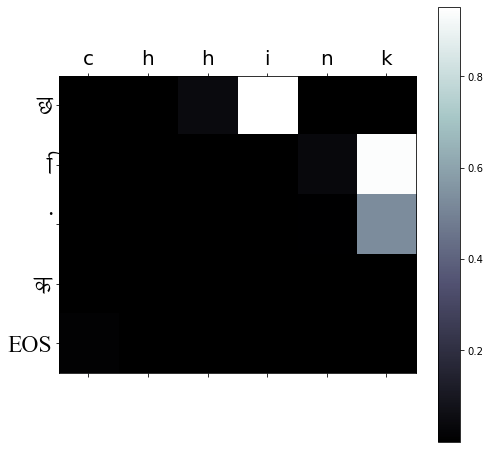

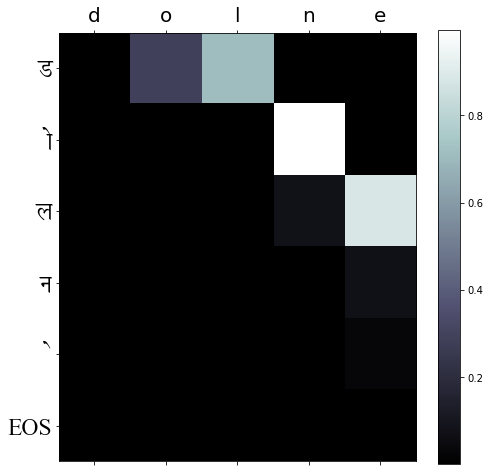

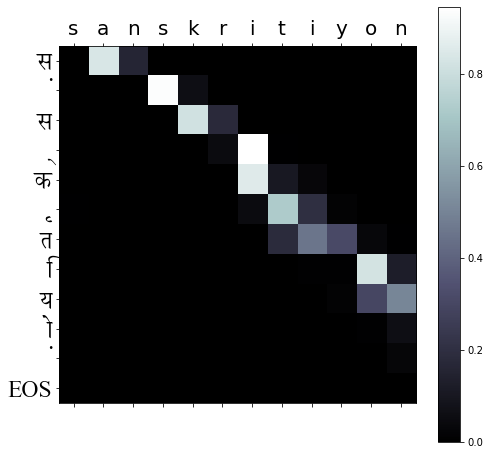

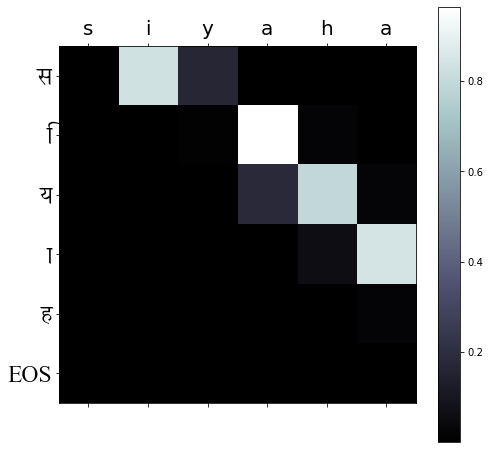

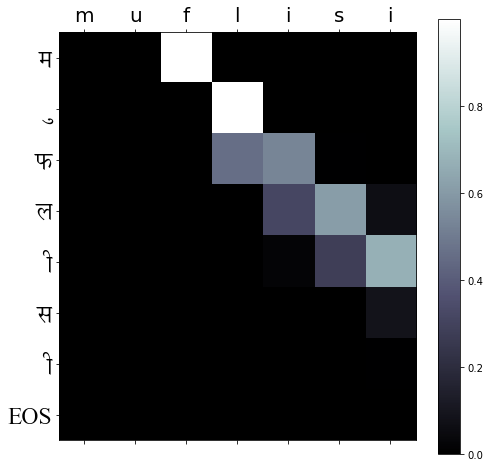

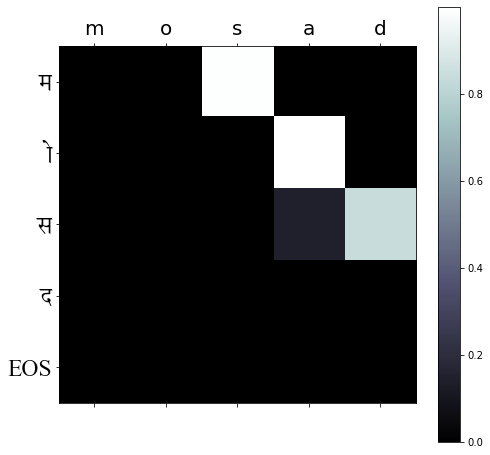

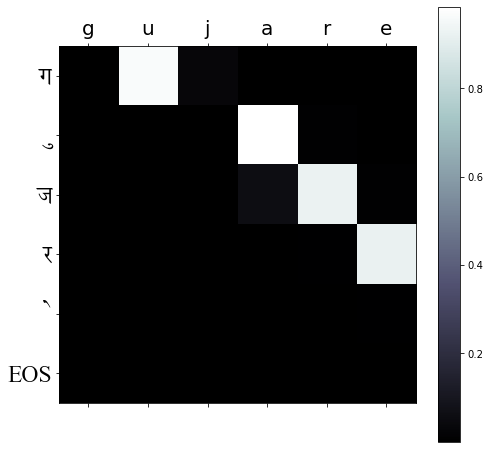

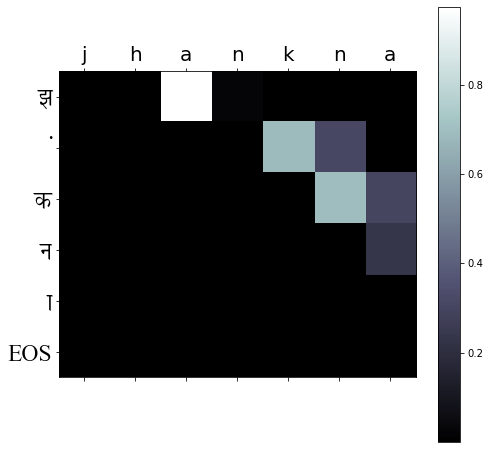

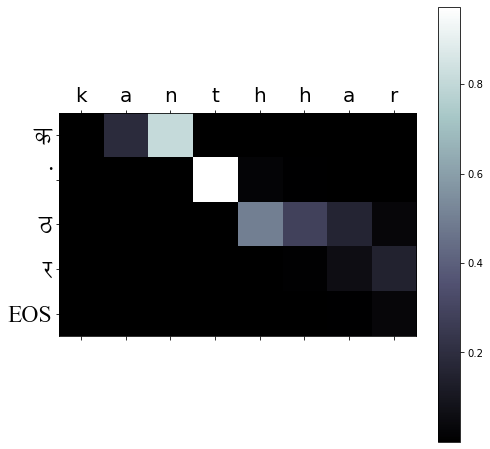

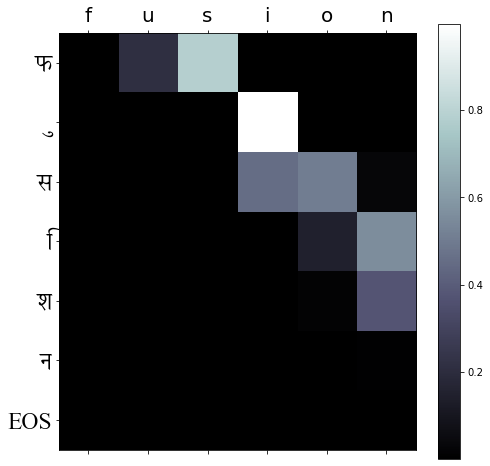

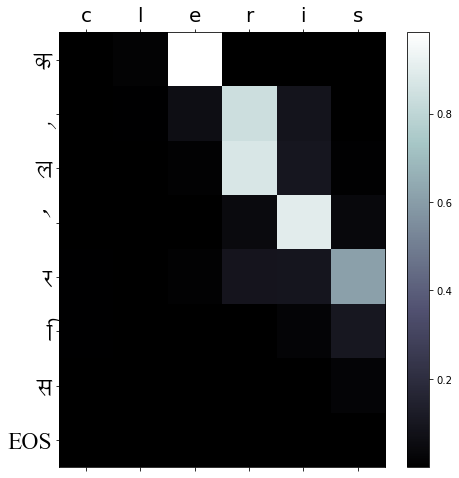

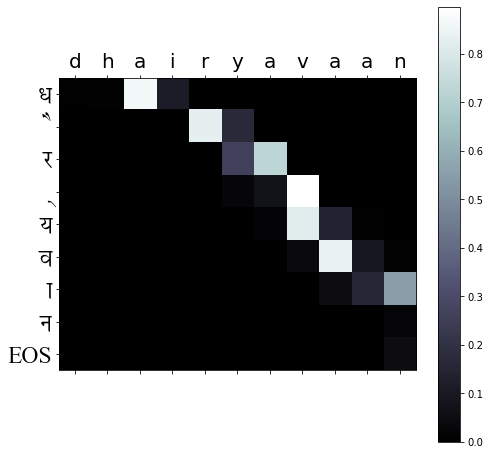

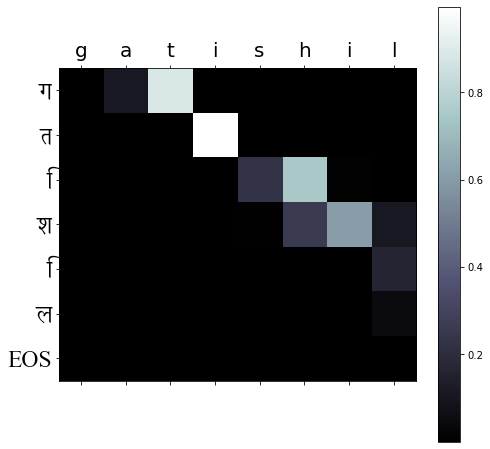

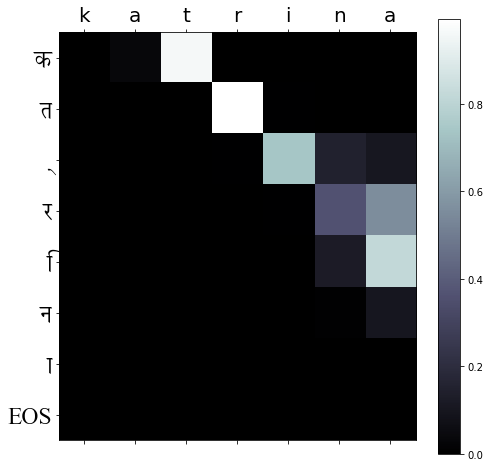

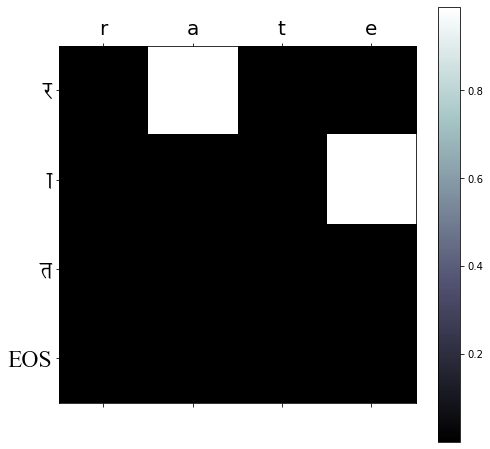

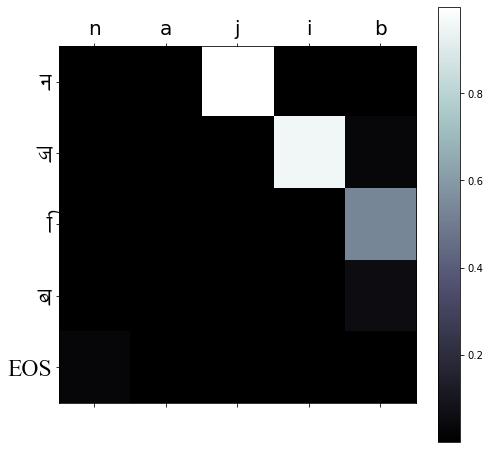

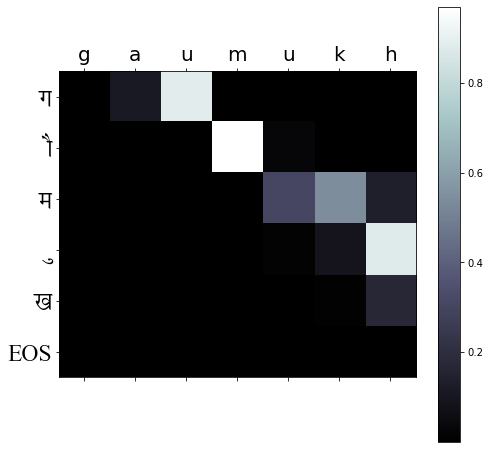

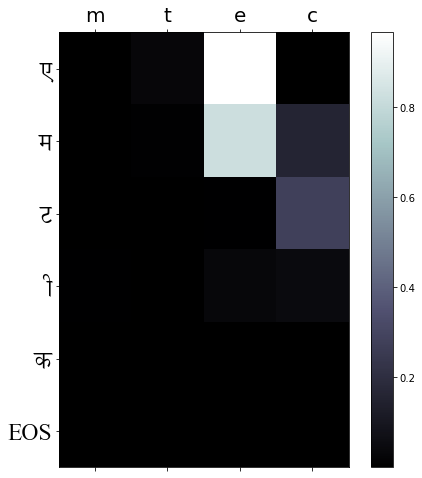

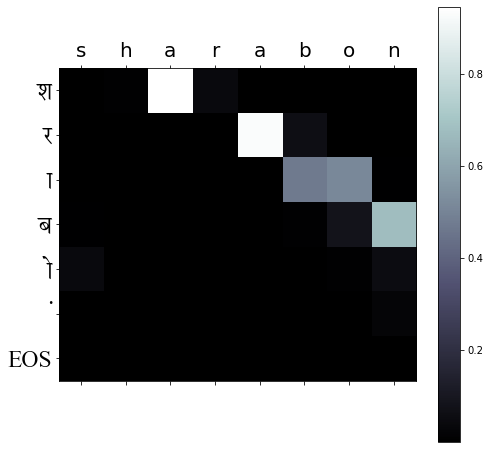

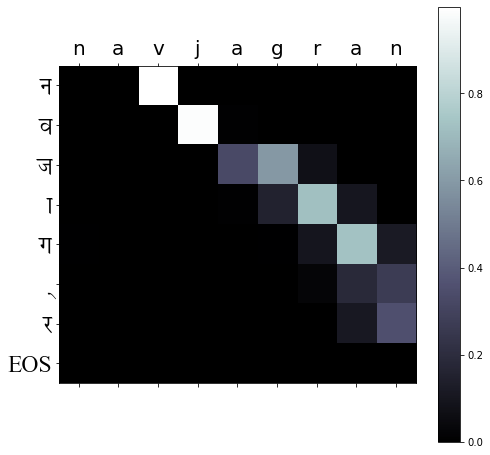

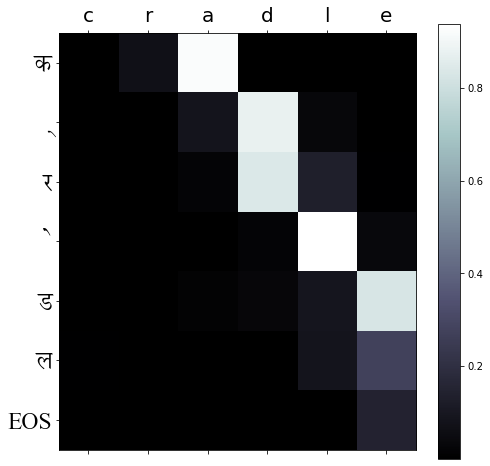

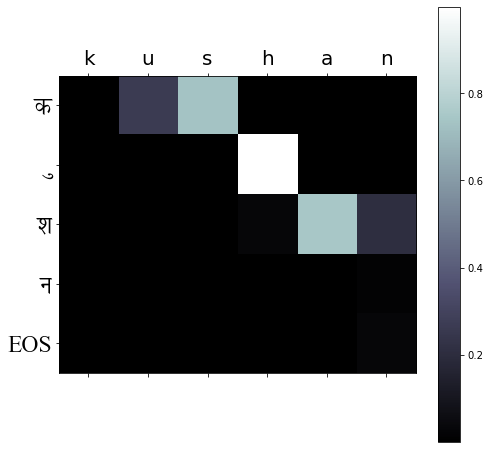

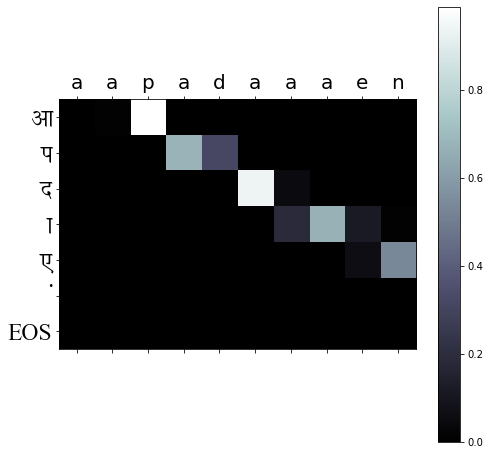

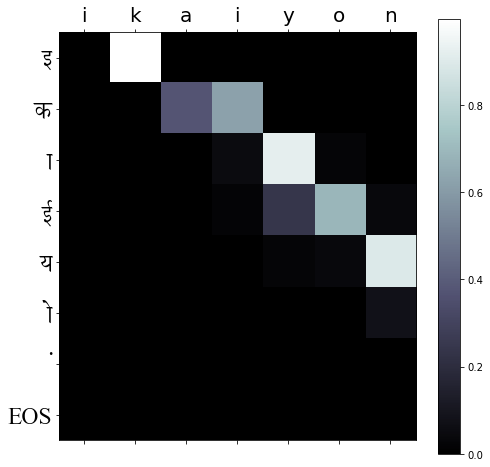

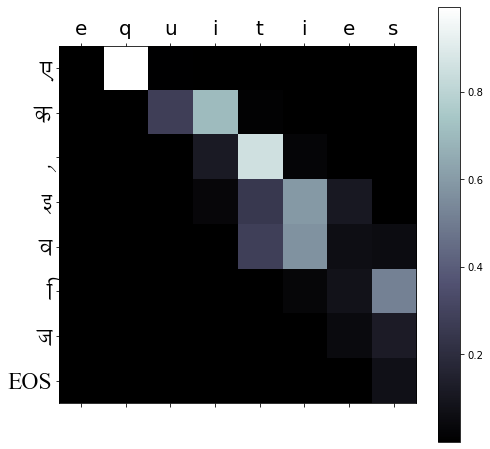

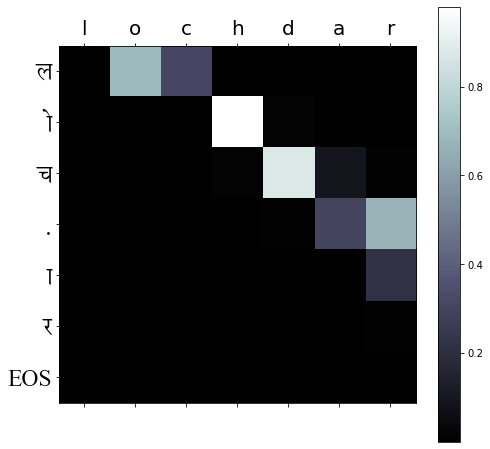

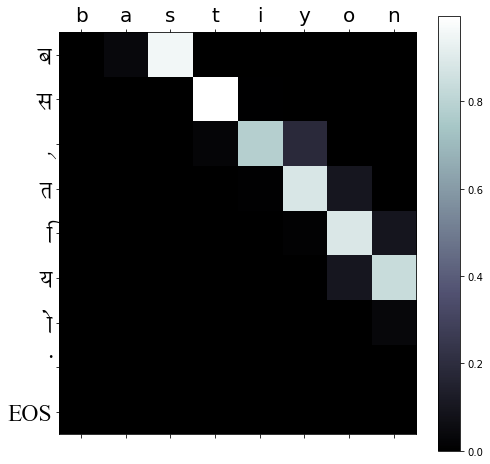

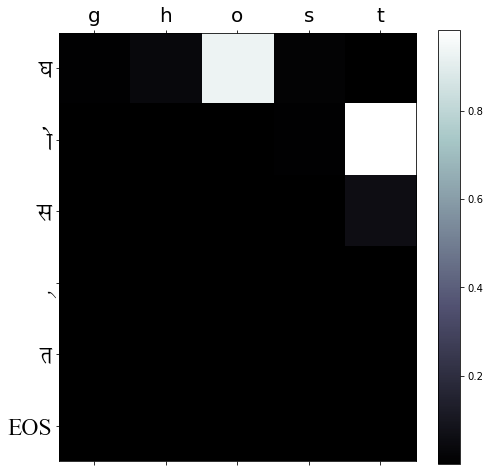

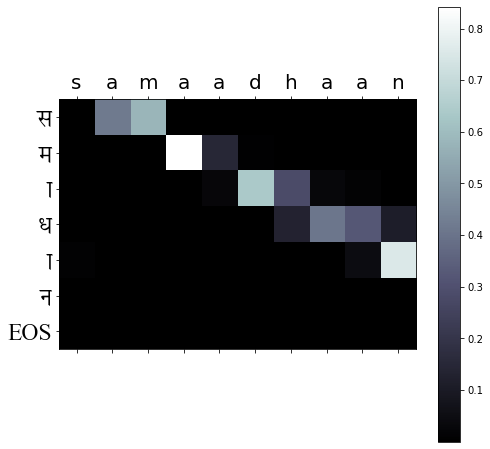

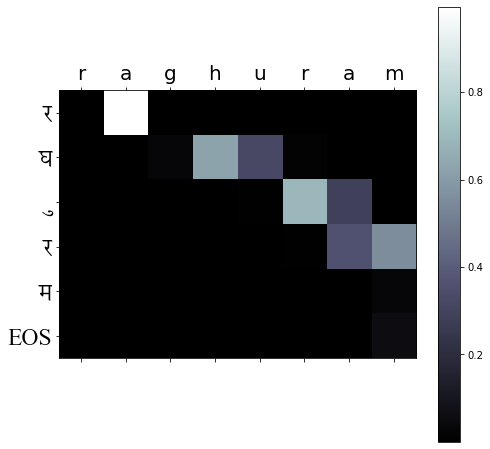

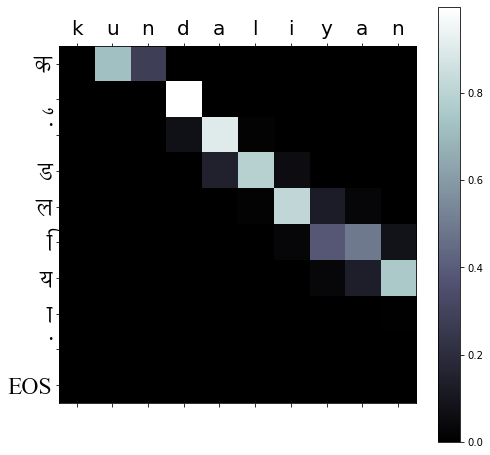

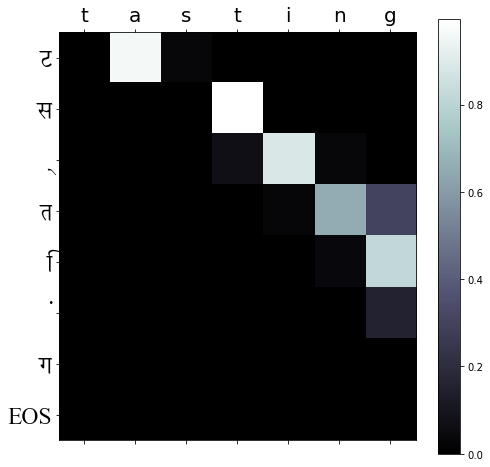

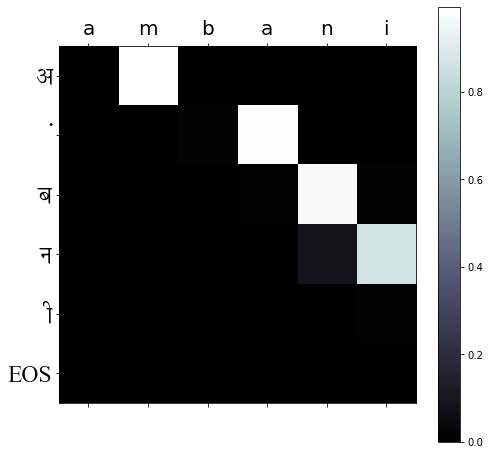

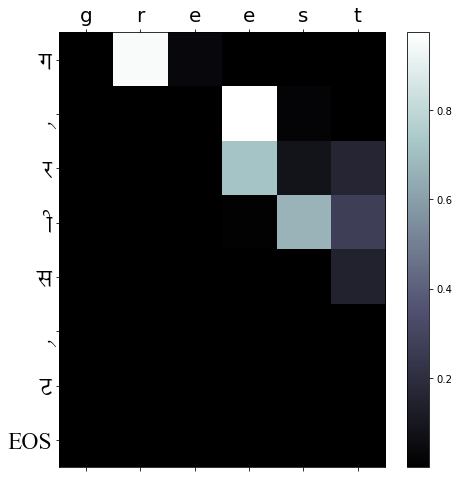

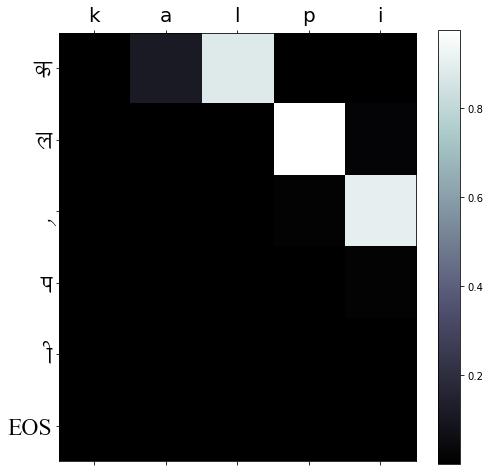

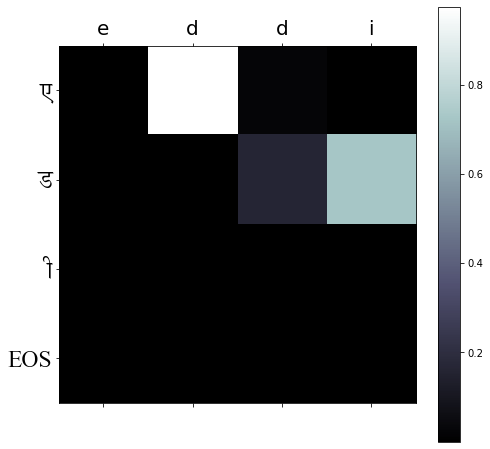

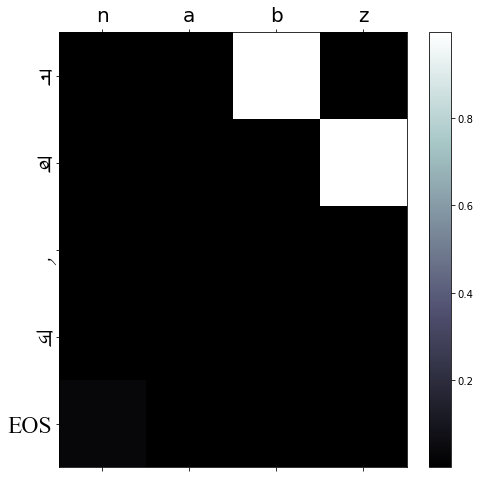

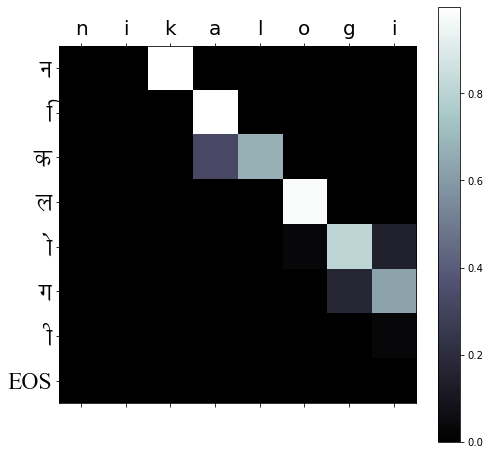

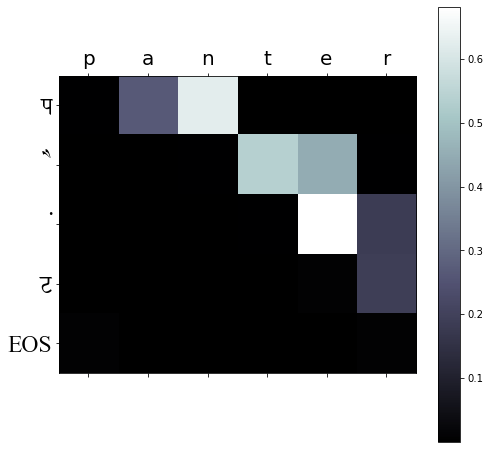

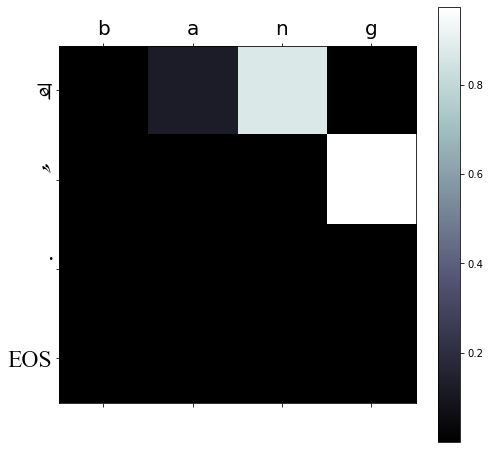

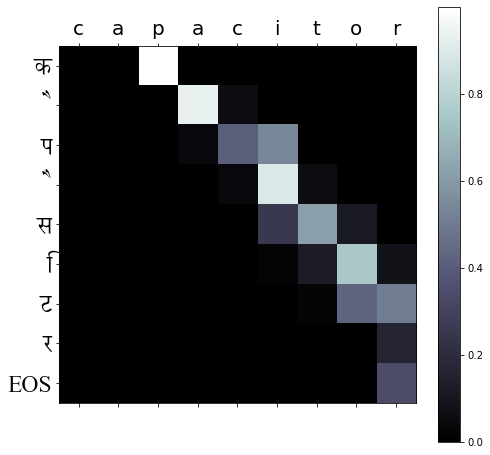

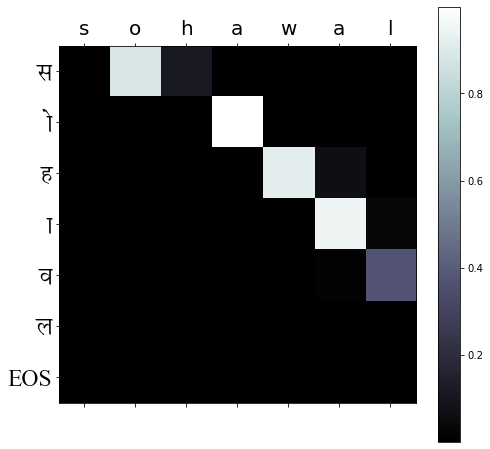

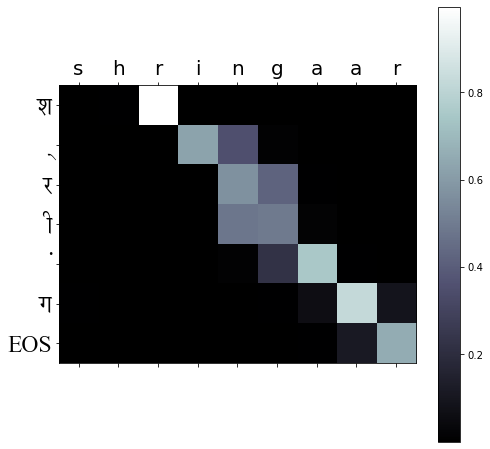

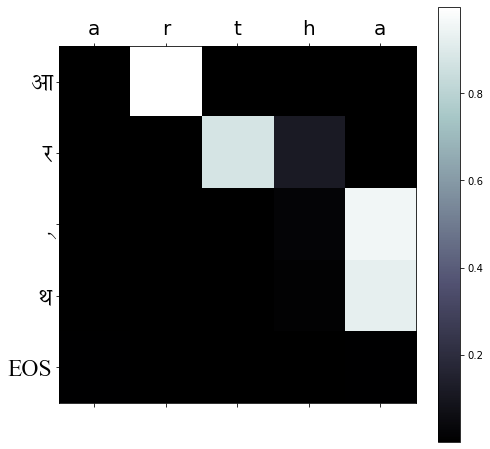

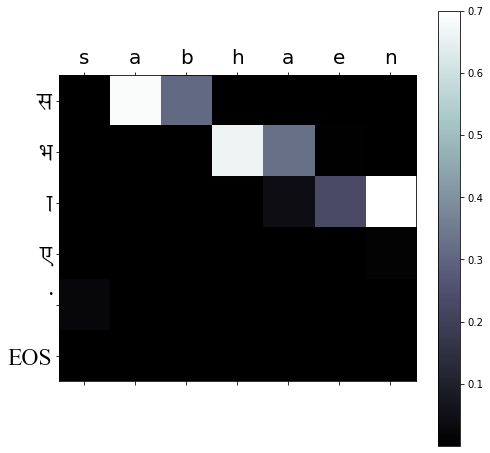

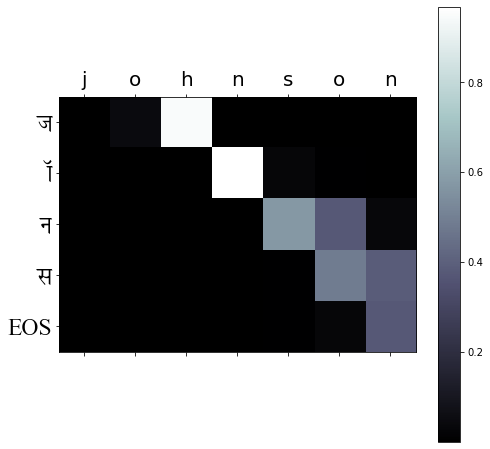

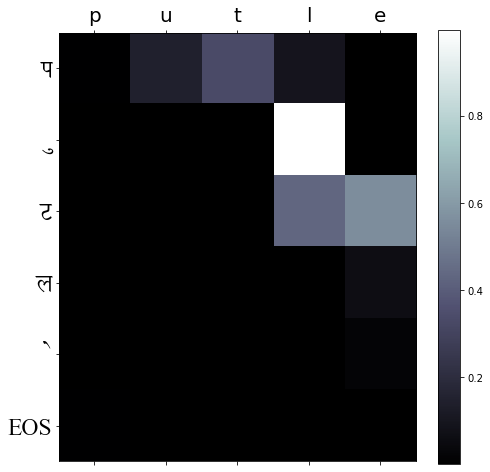

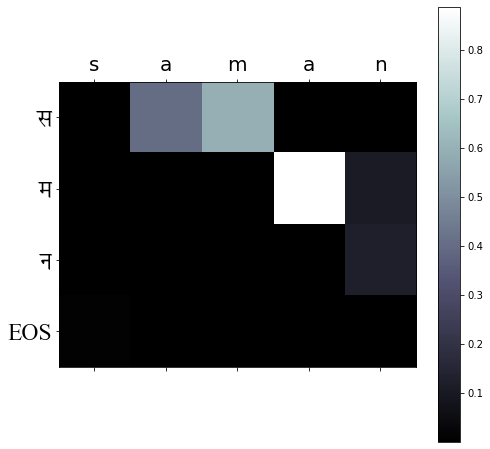

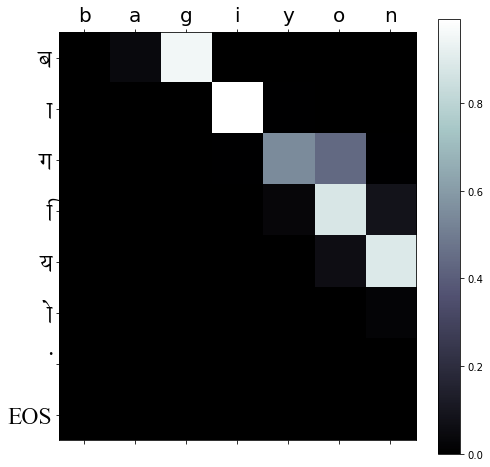

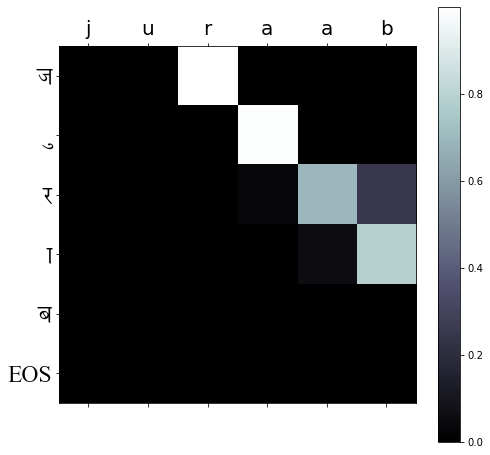

In [47]:
attention_heatmaps = []
for i in range(len(atten_log)):
    input_sentence = data_log[i][0]
    output_words = data_log[i][1]
    attentions = atten_log[i][1:]
    input_list = split(input_sentence)
    output_list = split(output_words)
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    atten_seq = []
    for x in attentions:
        atten_seq.append(np.array(x)[0,:len(input_sentence)])
        
    if len(atten_seq) > len(output_words):
        atten_seq = np.array(atten_seq[:len(output_words)+1])
        output_list.append('EOS')
        
    else:
        atten_seq = np.array(atten_seq[:len(output_words)])
    cax = ax.matshow(atten_seq, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_list, fontsize=20)
    ax.set_yticklabels([''] + output_list, fontproperties=hindi_font, fontsize=30)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    #plot = showAttention(data_log[i][0],data_log[i][1], atten_log[i][1:])
    attention_heatmaps.append(wandb.Image(
            fig, caption="Output: {} True: {}".format(data_log[i][1], data_log[i][2])))

In [48]:
wandb.log({"Attention Heatmaps : Test Dataset": attention_heatmaps})